# Data 11800 - Autumn 2022
# Homework 7: A/B testing and fuzzy matching (50 points)

**Reading**: Textbook chapter [12](https://inferentialthinking.com/chapters/12/Comparing_Two_Samples.html)

Please complete this notebook by filling in the cells provided. Before you begin, execute the following cell to load the needed functions. Each time you start your server, you will need to execute this cell again to load them.  

Homework 7 is due Thursday, Dec 1 at 9:00am. Late work will not be accepted.  

In [1]:
# Don't change this cell; just run it. 

import numpy as np
import pandas as pd

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# 1. Possum metrology (25 points) 

The data for this exercise were collected in Eastern Australia and represent various measurements of possum dimensions of 102 animals caught at 7 locations in Victoria, New South Wales, and Queensland in October and November of 1993. Source of data: 

Lindenmayer, D. B., Viggers, K. L., Cunningham, R. B., and Donnelly, C. F. 1995. Morphological variation among columns of the mountain brushtail possum, Trichosurus caninus Ogilby (Phalangeridae: Marsupiala). Australian Journal of Zoology 43: 449-458. 

Variables in the dataset:

- site: one of seven locations where possums were trapped. The sites were, in order, Cambarville, Bellbird, Whian Whian, Byrangery, Conondale, Allyn River and Bulburin
- pop:  a factor which classifies the sites as Vic (for Victoria) and other (New South Wales or Queensland)
- sex: a factor with levels f female, m male
- age (inferred from inspecting the teeth of the unlucky marsupials under sedation)
- head_l:  head length
- skull_w:  skull width
- total_l: total length
- tail_l: tail length

We believe that the units for `age` is  years, for `head_l`, `skull_w` and `tail_l` are mm; possums are about 30 cm long so  `total_l` and `tail_l` are in cm.  


In [2]:
# read the data
p_df = pd.read_csv("data/possum.csv")
p_df.head()

,site,pop,sex,age,head_l,skull_w,total_l,tail_l
0,1,Vic,m,8.0,94.1,60.4,89.0,36.0
1,1,Vic,f,6.0,92.5,57.6,91.5,36.5
2,1,Vic,f,6.0,94.0,60.0,95.5,39.0
3,1,Vic,f,6.0,93.2,57.1,92.0,38.0
4,1,Vic,f,2.0,91.5,56.3,85.5,36.0


In [3]:
# some data summaries
p_df.describe()

,site,age,head_l,skull_w,total_l,tail_l
count,104.000000,102.000000,104.000000,104.000000,104.000000,104.000000
mean,3.625000,3.833333,92.602885,56.883654,87.088462,37.009615
std,2.349086,1.909244,3.573349,3.113426,4.310549,1.959518
min,1.000000,1.000000,82.500000,50.000000,75.000000,32.000000
25%,1.000000,2.250000,90.675000,54.975000,84.000000,35.875000
50%,3.000000,3.000000,92.800000,56.350000,88.000000,37.000000
75%,6.000000,5.000000,94.725000,58.100000,90.000000,38.000000
max,7.000000,9.000000,103.100000,68.600000,96.500000,43.000000


**Question 1** Produce an adequately-labeled scatterplot of total length (y axis) vs. age (x axis). Explain why the plot has prominent vertical lines.

Text(0.5, 1.0, 'Relationship between Possium Length and Age')

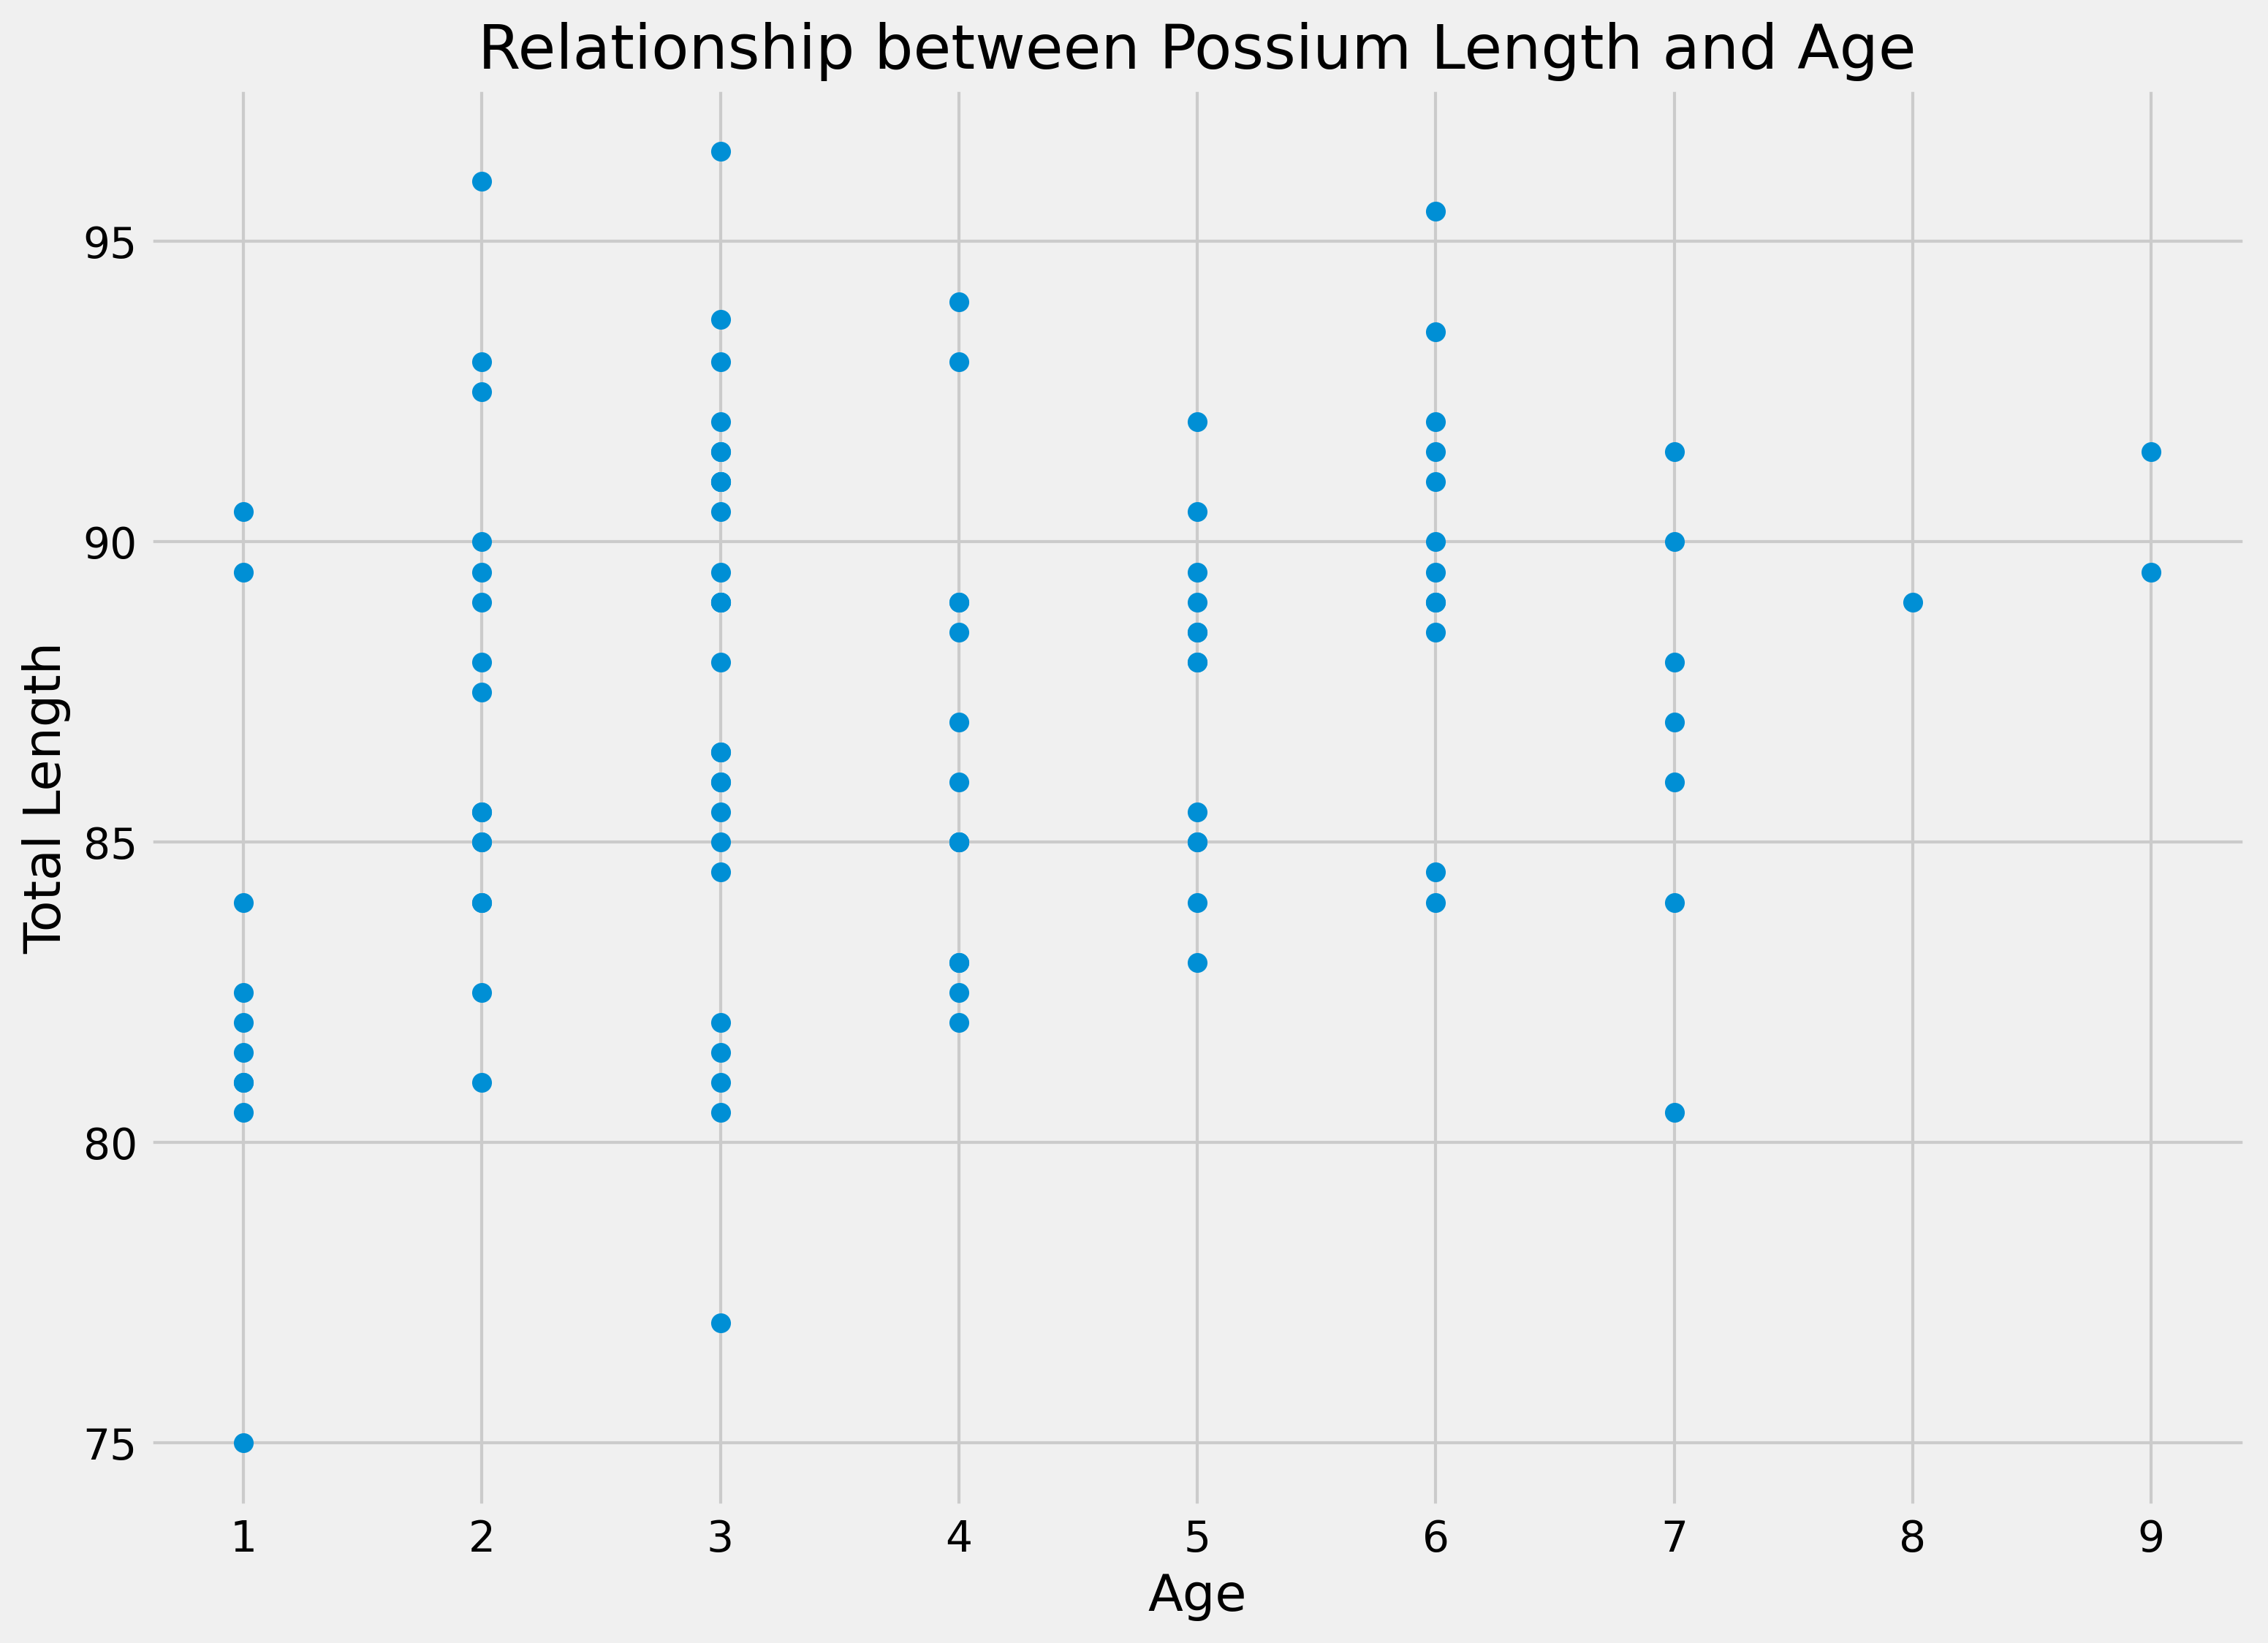

In [4]:
# code here
plt.figure(figsize=[11,8],dpi=300)
plt.scatter(p_df['age'],p_df['total_l'])
plt.xlabel('Age')
plt.ylabel('Total Length')
plt.title('Relationship between Possium Length and Age')

*Answer:* 


**Question 2.** Test for sexual dimorphism in the skull width measurement in the sampled possums.  (Do the male and female possums have different skull widths?)  This should be done using the permutation method. Display the (permutation generated) null distribution of your test statistic and the observed value of the test statistic. Report the p-value for this null hypothesis that the two sexes have the same skull width distribution.

In [ ]:
#  code here


**Question 3.** Simlarly to Question 2, test the hypothesis of equality in distributions for the tail lengths of male possums sampled in Victoria (sites 1 and 2) and the tail lengths of male possums sampled outside of Victoria.

This should be done using the permutation method. Display the (permutation generated) null distribution of your test statistics and the observed value of the test statistic. Report the p-value for this null hypothesis that the two groups have the same tail length distribution.

In [ ]:
# code here



**Question 4.** Write code that constructs a 2x2 table that shows the counts of sex (female and male) in the two sites (Victoria and other).

In [ ]:
# code here


**Question 5.** Investigate the hypothesis that the porportion of males to females is equal in the Victoria / non-Victoria populations trapped (perform a hypothesis test on the table you constructed in Question 4 using the permutation method). State clearly the null and alternative hypothesis. After you perform the test and report the p-value, briefly talk about the assumptions in your test.

In [ ]:
# code here


*Answer here:* 

## 2. Plagiarism detector (25 points) 

We will use the matching techniques discussed in Lecture 15 to construct **a naive plagiarism detector**. We modified the code from the class notebook in two ways: (i) we generalized it to q-character tokens; and (ii) we use spaces instead of #-signs to pad the ends of the strings.

This code allows you to calculate the Jaccard similarity for bigrams, trigrams etc.

In [ ]:
#A Function to break a string into qgrams (q-character tokens)
#we'll pad the string with spaces on the front and end
def qgram(str,q):
    str = ' ' + str + ' '
    return([str[i:i+q] for i in range(len(str)-(q-1))])

#compute the jaccard similarity of two strings using qgrams
#pass in a value for q to do anything other than bi-grams
#call jaccard_simq with verbose set to True to see intermediate values

def jaccard_simq(str1, str2,q=2,verbose=False): 
    set1 = set(qgram(str1,q)) 
    set2 = set(qgram(str2,q))
    common_tokens = set1.intersection(set2)
    all_tokens = set1.union(set2)
    if verbose:
        print('set1 =',set1)
        print('set2 =',set2)
        print('Intersection =',common_tokens)
        print('Union =',all_tokens)
        print('Common Tokens =',len(common_tokens),
              'Total Tokens =',len(all_tokens))
    return float(len(common_tokens) / len(all_tokens))


To familiarize yourself with the function, you should try it on several examples and with different values of q. The `verbose=True` option is useful when you want to understand what the function is doing.

In [ ]:
jaccard_simq('the quick brown fox','fox quick brown the',verbose=True)

In [ ]:
jaccard_simq('the quick brown fox','fox quick brown the')

In [ ]:
jaccard_simq('the quick brown fox','fox quick brown the',4,True)

In [ ]:
jaccard_simq('the quick brown fox','fox quick brown the',10)

The goal of this exercise is to use this function to investigate possible plagiarism in a homework assignment. A homework question asked students to define PageRank. The instructors were worried that the students will copy the answer from Wikipedia, so they decided to use that as a reference. The relevant part of the Wikipedia entry is saved in the file `original.txt` and the command below reads that file into a string.

In [ ]:
open("original.txt","r",encoding="utf8").read()

Files containing the answer of five students (A,B,C,D, and E) are provided. They are read as strings using the code below. 

In [ ]:
original=open("original.txt","r").read()
studentA=open("studentA.txt","r").read()
studentB=open("studentB.txt","r").read()
studentC=open("studentC.txt","r").read()
studentD=open("studentD.txt","r").read()
studentE=open("studentE.txt","r").read()


#### Question 1

One decision to make is the choice of q in the Jaccard similarity (whether to use 2-character tokens, 20-character tokens etc.) 

Write one advantage and one disadvantage when using 2-character tokens.

Write one advantage and one disadvantage when using 20-character tokens.

*Write your answer here, replacing this text.*


#### Question 2

Calculate the Jaccard similarities between each of the five student responses and the original Wikipedia article. This should be done for all q between 2 and 20.

Save the results in a dataframe with rows indexed by the values of q, and having a column for each student answer showing the similarity of that student answer and the original for each value of q.   Your dataframe should have 19 populated rows with 5 columns.

In [ ]:
# put your code to create and output the dataframe here
...

#### Question 3

Draw a plot with five overlaid lines for the Jaccard similarities of the five texts. The plot should show the Jaccard similarities (on y-axis) against q (on x-axis). Make sure that it is clear which line corresponds to which student/answer.

In [ ]:
# the code to draw the plot
...

#### Question 4

What do the similarity values you calculated say about the five students (A,B,C, D and E)? Is there evidence for plagiarism for any of them? Write a short discussion of your findings.


*Write your answer here, replacing this text.*


#### Question 5

Assume that the original text is fixed, but that different amounts of it are plagiarized.  How does the length of the plagiarized text impact the Jaccard similarities? For example, would a plagiarized short paper (1-2 sentences) typically have a different Jaccard similarity than a plagiarized long paper (few paragraphs)? Is this important for our five student scenario?

This is an open-ended question. You can answer it by changing the length of a plagiarized text and calculating similarities, you can argue it mathematically, or you can do some combination of these. 



In [ ]:
# if you use code to make your argument put it here
...

*Write your answer here, replacing this text.*
